## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

Using plaidml.keras.backend backend.


In [4]:
dataset_path = "../../LEGO_brick_custom/"
dataset_output = "./output"

In [5]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [6]:
def crop_random_shape_from_image(image: np.ndarray, cutter_shape: tuple = (200,200), verbose: bool = False) -> np.ndarray:
    '''Crop a randomly placed cutter_shape sized box from given image and returns it'''
    if(verbose):
        print(image.shape)
        print(cutter_shape)

    shape = image.shape

    if(cutter_shape[0] > shape[0] or cutter_shape[1] > shape[1]):
        raise ValueError("Cutter shape ", cutter_shape, " larger than one or more dimensions of given picture shape", shape[:2])
    
    x_1 = np.random.randint(0, shape[0] - cutter_shape[0])
    x_2 = x_1 + cutter_shape[0]

    y_1 = np.random.randint(0, shape[1] - cutter_shape[1])
    y_2 = y_1 + cutter_shape[1]

    if(verbose):
        print(x_1, x_2, y_1, y_2)
    
    result = image[x_1:x_2, y_1:y_2]
    
    return result

def overlay_transparent(background, overlay, x = 0, y = 0):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        raise ValueError("UwU")

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        raise ValueError("Not transparent")

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:]

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [7]:
class Background_source:

    def load_images(self):
        for img in os.listdir(self.path):
            img = cv2.imread(os.path.join(self.path, img))
            if(img is not None):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.background_images.append(img)
    
    def __init__(self, directory_path:str, crop_shape:tuple=(200,200), blur_kernel:tuple=(3,3)):
        self.path = directory_path
        self.crop_shape = crop_shape
        self.blur_kernel = blur_kernel
        self.background_images = []

        self.load_images()
    
    def apply_background(self, image):
        background = crop_random_shape_from_image(self.background_images[np.random.randint(len(self.background_images))], self.crop_shape)
        background = cv2.blur(background, self.blur_kernel)
        background = np.asarray(background, np.float32)
        background = background[:,:] / 255

        result = overlay_transparent(background, image / 255)

        alpha = np.ones(result.shape[:2])
        result = np.dstack((result, alpha)).astype(np.float32)
        result = result * 255

        return result

In [22]:
from keras.preprocessing.image import ImageDataGenerator

bg = Background_source("../../background_images", (200,200), (3,3))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=[1,1.2],
    height_shift_range=0.1,
    width_shift_range=0.1,
    brightness_range=[0.6,1],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = bg.apply_background
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = bg.apply_background
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode='categorical')

Found 26875 images belonging to 25 classes.
Found 11525 images belonging to 25 classes.


Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet but for this test we are using a simple one

In [23]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Input, Model

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(200,200,4), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3,3), activation="relu"))
model.add(Conv2D(256, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 198, 198, 32)      1184      
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 45, 45, 128)       73856     
__________

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model/model_vertical.png", show_shapes = True)
plot_model(model, to_file="model/model_horizontal.png", show_shapes = True, rankdir="LR")

In [24]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from datetime import datetime

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=12,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=4,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

#https://keras.io/guides/writing_your_own_callbacks/
class timeCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        _time = datetime.now()
        print(_time.strftime("%H:%M:%S"))

callbacks = [checkpoint, tensorboard, csvlogger, reduceLR, earlystop, timeCallback()]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [26]:
from keras.optimizers import Adam

#opt = SGD(lr=1e-3, nesterov="true") #not suited for deeper networks
opt = Adam(lr=5e-5)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 100,
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/100
840/840 [==============================] - 758s 902ms/step - loss: 3.1685 - acc: 0.0586 - val_loss: 2.8563 - val_acc: 0.1358

Epoch 00001: val_loss improved from inf to 2.85625, saving model to ./base.model
13:47:50
Epoch 2/100
840/840 [==============================] - 714s 849ms/step - loss: 2.8238 - acc: 0.1337 - val_loss: 2.4051 - val_acc: 0.2318

Epoch 00002: val_loss improved from 2.85625 to 2.40508, saving model to ./base.model
13:59:44
Epoch 3/100
840/840 [==============================] - 704s 838ms/step - loss: 2.5940 - acc: 0.1799 - val_loss: 2.2200 - val_acc: 0.2692

Epoch 00003: val_loss improved from 2.40508 to 2.21997, saving model to ./base.model
14:11:29
Epoch 4/100
840/840 [==============================] - 709s 845ms/step - loss: 2.4500 - acc: 0.2132 - val_loss: 2.0760 - val_acc: 0.2973

Epoch 00004: val_loss improved from 2.21997 to 2.07603, saving model to ./base.model
14:23:19
Epoch 5/100
840/840 [==============================] - 719s 856ms/step - los

In [10]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

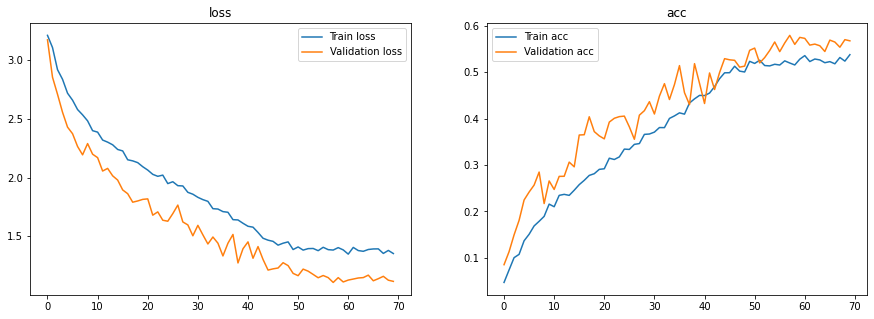

In [11]:
show_final_history(history)

We can try and test the model on random new images

In [12]:
#image_path = "../../LEGO_brick_images_v1/2357 Brick corner 1x2x2/201706171206-0001.png"
image_path = "../../LEGO_brick_images_v1/3004 Brick 1x2/0003.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
prediction = loaded_model.predict_classes(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 128)       73856     
__________

ValueError: Error when checking input: expected conv2d_1_input to have shape (200, 200, 4) but got array with shape (200, 200, 3)